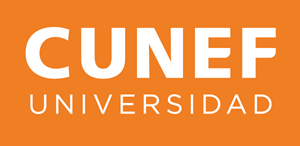
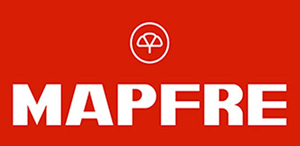

# Master en Data Science - Trabajo Final de Máster

# **4. Inferencia Causal**
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
### DataSet: *IBM - Telco Customer Churn*

En este notebook se procede a realizar el análisis principal del proceso: la inferencia y modelado causal.

En el mismo se podrá ver como se aplican las principales técnicas de inferencia y medición tanto del ATE como del CATE, pasando por un proceso de identificación del efecto causal, el descubrimiento causal en donde se generará un grafo causal y finalmente en el modelado causal, en donde se utilizarán los principales metalearners para medir el efecto causal condicional de cada instancia.

## Librerías y funciones

Sección en la que se importan las librerías públicas y también se importan funciones personalizadas desde un script propio.

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import importlib
import warnings
from toolz import curry
from IPython.display import Image, IFrame, display

# Modelos
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as statm
import statsmodels.formula.api as smf

# Modelado causal

## PyWhy
from causallearn.search.FCMBased import lingam
from causallearn.search.ConstraintBased.PC import pc
from dowhy import CausalModel
from econml.inference import BootstrapInference
from econml.metalearners import XLearner
from econml.dr import LinearDRLearner
from econml.dml import DML
## Grafos
import graphviz
import networkx as nx
import pyvis
from pyvis.network import Network
## Causal Inference
from causalinference import CausalModel as CausalModel2
## FKLearn
from fklearn.causal.validation.curves import *
from fklearn.causal.validation.auc import area_under_the_cumulative_effect_curve as auc_cec

# Configs
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(precision=3, suppress=True)

SEED=10
np.random.seed(SEED)

In [2]:
sys.path.append('../src/')
import functions_rfc_IBM as fr
importlib.reload(fr)
sys.path.remove('../src/')

## Carga del Dataset de entrenamiento

Se importa el dataset original de entrenamiento y luego se le realizan los preprocesamientos correspondientes

In [3]:
df_train = pd.read_parquet('../data/ibm_telco_churn/df_telco_train.parquet')
display(df_train.head(), df_train.shape)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
2125,0021-IKXGC,1,United States,California,San Marcos,92078,"33.119028, -117.166036",33.119028,-117.166036,Female,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,72.10,No,50,4432,None,0
6768,1395-OFUWC,1,United States,California,Los Angeles,90067,"34.057496, -118.413959",34.057496,-118.413959,Male,No,Yes,Yes,43,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,1224.05,No,70,4741,None,0
6796,8080-POTJR,1,United States,California,Rancho Palos Verdes,90275,"33.753146, -118.367459",33.753146,-118.367459,Female,No,No,No,30,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2427.10,No,78,2655,None,0
476,3132-TVFDZ,1,United States,California,Glendale,91202,"34.167926, -118.267539",34.167926,-118.267539,Male,Yes,Yes,No,57,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.85,2572.95,Yes,82,5172,Attitude of support person,1
6706,3898-BSJYF,1,United States,California,Herlong,96113,"40.198234, -120.18089",40.198234,-120.180890,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,29,4434,None,0


In [4]:
X = df_train.drop(columns='Churn Value', axis=1)
y = df_train['Churn Value']

X.shape, y.shape

## Preprocesamiento

Se aplican funciones de selección de variables, clasificación de tipos y preprocesamiento

In [5]:
X_s = fr.feature_selection(X)
display(X_s.head(),X_s.shape)

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Contract,Paperless Billing,Payment Method,Monthly Charges,CLTV
2125,Yes,No,No,1,Yes,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,4432
6768,No,Yes,Yes,43,No,DSL,No,Yes,No,No,Month-to-month,No,Credit card (automatic),29.30,4741
6796,No,No,No,30,Yes,DSL,Yes,No,Yes,No,One year,Yes,Credit card (automatic),79.30,2655
476,Yes,Yes,No,57,No,DSL,No,No,No,No,Month-to-month,Yes,Electronic check,44.85,5172
6706,No,No,Yes,10,Yes,DSL,Yes,No,Yes,Yes,One year,No,Credit card (automatic),73.55,4434


In [6]:
bools, cats, nums = fr.tipos_vars(X_s)

(boolean) - Senior Citizen :  ['Yes' 'No']
(boolean) - Partner :  ['No' 'Yes']
(boolean) - Dependents :  ['No' 'Yes']
(numeric) - Tenure Months : Range = [0.00 to 72.00], Mean = 32.90
(boolean) - Phone Service :  ['Yes' 'No']
(boolean) - Internet Service :  ['Fiber optic' 'DSL']
(boolean) - Online Security :  ['No' 'Yes']
(boolean) - Online Backup :  ['No' 'Yes']
(boolean) - Device Protection :  ['No' 'Yes']
(boolean) - Tech Support :  ['No' 'Yes']
(categoric)(Type: object) - Contract : ['Month-to-month', 'One year', 'Two year']
(boolean) - Paperless Billing :  ['Yes' 'No']
(categoric)(Type: object) - Payment Method : ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
(numeric) - Monthly Charges : Range = [23.45 to 118.75], Mean = 76.86
(numeric) - CLTV : Range = [2003.00 to 6500.00], Mean = 4410.36


In [7]:
preprocessor = fr.Preprocessing(X_s,
                                cat_transf='mix',
                                scale=True,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['Payment Method']
        Numerical transformation (scaling=True input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [8]:
preprocessor.fit(X_s, y)
X_t = preprocessor.transform(X_s)
display(X_t.head(), X_t.shape)

,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing
2125,-1.299099,-0.217742,0.018351,0.0,0.471083,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6768,0.411249,-2.175807,0.280323,0.0,0.190022,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6796,-0.118144,0.111652,-1.488203,1.0,0.190022,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
476,0.981365,-1.464407,0.645728,0.0,0.471083,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6706,-0.932596,-0.151406,0.020046,1.0,0.190022,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


# **1. Identificación del efecto causal**

En esta primera sección, se expondrá el análisis más simple y básico de la inferencia causal mediante el machine learning, pero no por ello menos efectivo, sino al contrario, es sorprendente la gran capacidad de mitigación de sesgos y de apreciación de los efectos causales que nos puede brindar uno de los modelos más básicos de machine learning: La regresión lineal.

En primer lugar, se expondrá la base del análisis: el uso de la regresión lineal y sus coeficientes para medir el efecto causal. A su vez, se expondrá el teorema FLW, el cual permite explicar el proceso de la regresión lineal, separándo el proceso del modelo en 3 instancias: Debiasing, Denoising y Final Outcome Model.

Una vez realizado este proceso manual, también se implementa una de las librerías más básicas de inferencia causal: CausalInference, la cual permite calcular de manera muy simple el ATE, además de implementar otros métodos básicos como el propensity score y la eliminación de sesgos de selección via matching.

Se puede tomar a esta sección como la introducción al análisis causal, mientras que el las siguientes se introducirán métodos más complejos de inferencia causal.

## Linear Regression Causal Analysis

En la bibliografía moderna de la inferencia causal se suele presentar a la regresión lineal como una de los principales herramientas para medir el efecto causal entre variables, debido a la increíble capacidad de "debiasing" que posee, término que en español sería mitigación de sesgos. Uno de los autores que más influencia ha tenido sobre el presente estudio define a esta capacidad mencionándola como "the unreasonable efectiveness of Linear Regression", en referencia a que uno de los modelos más simples de machine learning muestra capacidades muy valiosas para este tipo de inferencias.

A continuación se procederá a realizar un procedimiento que mostrará los pasos por los que se compone la regresión, utilizando al teorema de Frisch-Waugh-Lovell, que explica la separación del modelo en 3 pasos.

Este proceso no solo nos permite deshacernos del principal sesgo en los problemas de causalidad: el confounding bias, ya que mediante la ortogonalización permite medir las relaciones entre variables como si se tratase de un experimento randomizado, ya que elimina los sesgos provenientes de las relaciones con las demas variables (potenciales confounders), pudiendo aislar la relación entre el treatment y el outcome.

Finalmente y como resultado, los coeficientes permiten medir de una manera mucho más efectiva que un coeficiente de correlación, la asociación causal que se busca realmente.

### Paso 1: Debiasing step

En el primer paso del teorema FLW se procede a calcular una regresión lineal básica, pero en este caso no se buscará predecir al target (Churn Value), sino que lo primero que haremos será **predecir al treatment** (Tech Support). Con estas predicciones obtendríamos la propención a recibir el tratamiento de cada cliente. Aún así, lo que nos interesará obtener a nosotros de este modelo seran los **residuos** de la variable treatment. Estos residuos pueden calcularse restando las predicciones de la regresión al valor original de la variable treatment ($\~T = T - \^T$), ya que, a diferencia de Statmodels, SKLearn no ofrece un método que devuelve directamente los residuos.

Esto se debe a que esos residuos serán básicamente la parte de la variable que NO se ve explicada por las demás covariates, y por ende, no posee el confounding bias incrustado. Por ello es que se menciona a estos residuos como la parte 'debiased' de la variable treatment.

Antes de proceder, se realiza un disclaymer importante: No es menor el dejar en claro de que una regresión lineal no sería el modelo más adecuado a aplicar si el objetivo final fuese predictivo, ya que estamos tratando con variables categóricas, tanto en el treatment como en el outcome. Sin embargo, para este tipo de análisis si que tiene sentido utilizar con cuidado esta técnica, al menos a modo ilustrativo como la base de la inferencia causal. Luego se mostrarán modelos más complejos aplicados a dicho análisis y que permiten obtener resultados similares o mejores aún.

A continuación el cálculo:

In [12]:
t = X_t['Tech Support'] # defino la variable treatment como t

# Regresión lineal de t:

lr_t = LinearRegression()

lr_t.fit(X_t.drop('Tech Support', axis=1), t)

lr_t.coef_

array([ 0.002,  0.343, -0.004,  0.152, -0.277, -0.068, -0.034,  0.025,
       -0.294, -0.576, -0.032, -0.057, -0.074, -0.025])

Este modelo además nos permite visualizar los coeficientes para medir cuales son las variables más influyentes sobre el treatment:

In [13]:
# tabla con los coeficientes por variable:
coefs = pd.DataFrame([lr_t.coef_], columns=X_t.drop('Tech Support', axis=1).columns)
coefs = coefs.T
coefs.columns = ['coef']
coefs.style.background_gradient(cmap='coolwarm')

,coef
Tenure Months,0.002252
Monthly Charges,0.343007
CLTV,-0.003838
Contract,0.151501
Payment Method,-0.276674
Senior Citizen,-0.068449
Partner,-0.033899
Dependents,0.025083
Phone Service,-0.294364
Internet Service,-0.576180


Como curiosidad, podemos ver que se obtiene un resultado que difiere con el del Random Forest del notebook 02, primero debido a que la naturaleza de los modelos es distinta, pero aún así, esto también tiene que ver con el proceso de debiasing de la regresión, en donde variables como 'Contract' sigue teniendo alta importancia, pero a su vez se ve opacada por variables que parecen tener una mayor importancia de fondo, como el tipo de servicio de internet o de telefonía contratado que tenga el cliente sobre todo, o también por el pago mensual (que está obviamente relacionado a los servicios extras) y el método de pago.

In [14]:
# calculo los residuos de la variable treatment:
resid_t = t - lr_t.predict(X_t.drop('Tech Support', axis=1))
X_t_regre = X_t.copy()
X_t_regre['treatment_resid'] = resid_t
X_t_regre['treatment_resid_origin_scale'] = X_t_regre['treatment_resid'] + X_t_regre['Tech Support'].mean()
X_t_regre.head()

,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing,treatment_resid,treatment_resid_origin_scale
2125,-1.299099,-0.217742,0.018351,0.0,0.471083,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.109124,0.479621
6768,0.411249,-2.175807,0.280323,0.0,0.190022,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.198633,0.171863
6796,-0.118144,0.111652,-1.488203,1.0,0.190022,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.780143,-0.409646
476,0.981365,-1.464407,0.645728,0.0,0.471083,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.302635,0.067862
6706,-0.932596,-0.151406,0.020046,1.0,0.190022,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.267265,0.637761


### Paso 2: Denoising step

Como segundo paso del proceso, se procede a generar una nueva regresión lineal, para calcular la propensión de la variable outcome/target, es decir, la propención a la fuga de los clientes, aunque en este caso sin incluír como variable explicativa al treatment. Nuevamente, este cálculo no se realiza con el fin último de predecir al target, sino para obtener los residuos de esta variable ($\~Y = Y - \^Y$).

En este paso del proceso, no tan importante como el anterior, pero útil, se busca eliminar ruido del modelo, en cuanto a que aislará la relación del outcome de las demás variables, disminuyendo en el proceso la varianza del coeficiente final del paso 3.

A continuación el cálculo:

In [15]:
lr_y = LinearRegression()

lr_y.fit(X_t.drop('Tech Support', axis=1), y)

lr_y.coef_

array([-0.14 ,  0.06 ,  0.005, -0.051,  0.268,  0.031,  0.032, -0.18 ,
       -0.1  ,  0.092, -0.069, -0.035, -0.04 ,  0.051])

In [16]:
coefs = pd.DataFrame([lr_y.coef_], columns=X_t.drop('Tech Support', axis=1).columns)
coefs = coefs.T
coefs.columns = ['coef']
coefs.style.background_gradient(cmap='coolwarm')

,coef
Tenure Months,-0.140117
Monthly Charges,0.060324
CLTV,0.004885
Contract,-0.050542
Payment Method,0.267916
Senior Citizen,0.031292
Partner,0.031774
Dependents,-0.180275
Phone Service,-0.100404
Internet Service,0.091906


In [17]:
# residuos de y
resid_y = y - lr_y.predict(X_t.drop('Tech Support', axis=1))
X_t_regre['y_resid'] = resid_y
X_t_regre['y_resid_origin_scale'] = X_t_regre['y_resid'] + y.mean()
X_t_regre.head()

,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing,treatment_resid,treatment_resid_origin_scale,y_resid,y_resid_origin_scale
2125,-1.299099,-0.217742,0.018351,0.0,0.471083,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.109124,0.479621,-0.704028,-0.385650
6768,0.411249,-2.175807,0.280323,0.0,0.190022,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.198633,0.171863,-0.014638,0.303739
6796,-0.118144,0.111652,-1.488203,1.0,0.190022,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.780143,-0.409646,-0.193157,0.125220
476,0.981365,-1.464407,0.645728,0.0,0.471083,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.302635,0.067862,0.647372,0.965750
6706,-0.932596,-0.151406,0.020046,1.0,0.190022,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.267265,0.637761,-0.067262,0.251115


### Paso 3: Final Outcome Model

En el tercer paso del proceso simplemente se unifican los resultados de los dos pasos anteriores, utilizando los residuos de la variable treatment para predecir los residuos de la variable outcome. De esta manera, se realiza una predicción fuertemente reducida de sesgos y ruidos de las demas covariables, permitiendo obtener como resultado un coeficiente realista sobre el impacto causal real de una variable sobre la otra.

A continuación el cálculo:

In [18]:
# modelo final
lr_final = LinearRegression()

lr_final.fit(X_t_regre['treatment_resid'].values.reshape(-1,1), X_t_regre['y_resid'])

lr_final.coef_

array([-0.069])

En este caso vemos que el modelo arroja un coeficiente de -0.069 para definir la relación entre el tratamiento y la variable target. Este es justamente el ATE! Es decir, el efecto promedio del tratamiento sobre la variable target en un contexto sin sesgos. Esto significa que la aplicación de la variable treatment implicaría una disminución de la propención a fuga del cliente de 0.069 sobre uno, es decir, aprox un 7%.

Lo primero a comentar es que, a diferencia de el coeficiente de correlación de cramers calculado en el notebook 01, ya tenemos una cardinalidad clara, es decir, que la relación entre ambas variables es inversa (como indica la lógica). Además, notamos que en un análisis sin sesgos, el impacto causal es en realidad menor que el notado con anterioridad, lo cual también parece lógico, ya que el tratamiento puede ayudar a la retención, pero no parece ser un factor sumamente determinante (si fuese tan claro, probablemente se hubiesen tomado acciones con anterioridad).

De igual manera, se obtiene una confirmación de que el tratamiento realmente podría disminuír la propención a la fuga, en un término no tan alto pero ciertamente relevante. El mismo análisis podría realizarse para otras variables y es totalmente extendible siempre que tenga lógica de negocio, algo sobre lo que se profundizará en el cuerpo del TFM.

### Uniendo todos los pasos en una Regresión Lineal simple

Finalmente, se procede a realizar una regresión lineal completa, para demostrar que se obtiene exáctamente el mismo resultado. El proceso que se llevó a cabo es todo lo que realiza por dentro la regresión lineal para cada una de las variables que la componen, otorgando así coeficientes sin sesgos debido a la ortogonalización:

In [19]:
# sin pasos

lr = LinearRegression()

lr.fit(X_t, y)

lr.coef_

array([-0.14 ,  0.084,  0.005, -0.04 ,  0.249,  0.027,  0.029, -0.179,
       -0.121,  0.052, -0.072, -0.039, -0.045, -0.069,  0.049])

In [20]:
coefs = pd.DataFrame([lr.coef_], columns=X_t.columns)
coefs = coefs.T
coefs.columns = ['coef']
coefs.reset_index(names='variable', inplace=True)
coefs.style.applymap(lambda x: 'background-color: cyan' if x == 'Tech Support' else '').background_gradient(cmap='coolwarm')

,variable,coef
0,Tenure Months,-0.139962
1,Monthly Charges,0.084061
2,CLTV,0.004620
3,Contract,-0.040058
4,Payment Method,0.248770
5,Senior Citizen,0.026555
6,Partner,0.029428
7,Dependents,-0.178540
8,Phone Service,-0.120774
9,Internet Service,0.052033


Se puede apreciar como el coeficiente para el treatment es el mismo. Además, se obtienen los coeficientes de las demás variables, resaltando claramente el método de pago y los dependientes, entre otras variables importantes.

Aquí es donde nuevamente es importante el entendimiento de negocio y el contexto empresarial, para determinar que variables pueden tener un análisis más o menos lógico en base a la situación de mercado. Es decir, Tech Support es una variable elegida como treatment debido a que es un servicio que la empresa puede ofrecer de manera proactiva al cliente en búsqueda de mejorar la retención, lo mismo que puede pasar con muchos otros servicios ya existentes o específicos de la empresa para mejorar la retención. Mientras que otras variables más bien demográficas como si la persona está en pareja, tiene dependientes o no son prácticamente intocables. Entre medio de ellas puede encontrarse también el método de pago, ofreciendo promociones o facilidades para cambiar, pero si el cliente simplemente no quiere modificarlo o no posee otros medios, no se podrán ejecutar acciones.

Es por estos motivos que muchas veces los análisis causales más potentes se dan cuando se buscan medir acciones específicas en poder de la empresa como lo pueden ser acciones de marketing, o también en los casos más clásicos como los de medicina, en donde se busca medir el efecto de un tratamiento en una muestra específica.

Aún así, lo interesante de este modelado es la búsqueda de expandir el uso de estos modelos de casos específicos a otras aplicaciones de negocio.

### Análisis similar, pero con Regresión Logística

Ante el posible cuestionamiento del uso de la regresión lineal para la predicción de variables categóricas, también se procede a utilizar una regresión logística, con el fin de mostrar que la direccionalidad del análisis es la misma.

A pesar de ser muy útil y en casos puramente predictivos más acertada, la regresión logística muestra una desventaja clara a la hora de medir estos coeficientes, y es que no deja de ser un GLM (Generalized Linear Model), que aplica una transformación a las variables utilizando la distribución logística, es decir, aplicando una función logit.

Esto da como resultado que los coeficientes tengan una transformación de por medio y por ende el resultado no se tan transparente como el de la regresión lineal. Por ende, los coeficientes, como se muestra a continuación, tienen una direccionalidad y peso relativamente similar, pero su lectura no es lineal y transparente como lo serían los de la regresión lineal.

A continuación el cálculo:

In [21]:
log_r = LogisticRegression()

log_r.fit(X_t, y)

log_r.coef_

array([[-0.806,  0.58 ,  0.015, -0.631,  1.083,  0.105,  0.207, -1.486,
        -0.874,  0.235, -0.514, -0.249, -0.27 , -0.461,  0.338]])

In [22]:
coefs_logr = pd.DataFrame(log_r.coef_, columns=X_t.columns)
coefs_logr = coefs_logr.T
coefs_logr.columns = ['coef']
coefs_logr.reset_index(names='variable', inplace=True)
coefs_logr

,variable,coef
0,Tenure Months,-0.805904
1,Monthly Charges,0.580038
2,CLTV,0.014996
3,Contract,-0.630626
4,Payment Method,1.083130
5,Senior Citizen,0.105413
6,Partner,0.207255
7,Dependents,-1.486127
8,Phone Service,-0.874405
9,Internet Service,0.234573


Muestra de ambos coeficientes resultantes emparentados:

In [23]:
(pd.merge(coefs, coefs_logr, on='variable', suffixes=('_lin', '_logr'))
 .style.applymap(lambda x: 'background-color: cyan' if x == 'Tech Support' else '')
 .background_gradient(cmap='coolwarm')
)

,variable,coef_lin,coef_logr
0,Tenure Months,-0.139962,-0.805904
1,Monthly Charges,0.084061,0.580038
2,CLTV,0.004620,0.014996
3,Contract,-0.040058,-0.630626
4,Payment Method,0.248770,1.083130
5,Senior Citizen,0.026555,0.105413
6,Partner,0.029428,0.207255
7,Dependents,-0.178540,-1.486127
8,Phone Service,-0.120774,-0.874405
9,Internet Service,0.052033,0.234573


Se puede apreciar como la cardinalidad es exáctamente igual y el peso relativo es relativamente similar en prácticamente todas las variables, entre ellas el target. Solo puede apreciarse cómo en el caso de la logística los dependientes parecen tener más importancia que el método de pago y en la lineal en viceversa, pero en ambos casos son las dos principales variables.

## Librería CausalInference

A continuación se procede a realizar un análisis de inferencia causal similar al reciente, pero en este caso aplicando las funcionalidades de la librería CausalInference, la cual nos permite ahorrarnos cálculos y nos presenta los resultados de una manera agradable:

Generación del "Modelo Causal" de la librería y estimación del ATE:

In [21]:
# defino modelo con Y=outcome, D=treatment y X=covariates
causal = CausalModel2(
    Y=y.values, 
    D=X_t['Tech Support'].values, 
    X=X_t.drop(['Tech Support'],axis=1).values)

causal.est_via_ols(adj=1)

print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.069      0.015     -4.757      0.000     -0.098     -0.041



El modelo también ofrece una visión de las principales estadísticas de los grupos de control y tratados, con sus diferencias a la vista:

In [22]:
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=2778)        Treated (N_t=1635)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.417        0.493        0.150        0.358       -0.267

                      Controls (N_c=2778)        Treated (N_t=1635)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.291        0.916        0.494        0.942        0.845
             X1       -0.098        0.976        0.166        1.018        0.265
             X2       -0.110        1.016        0.186        0.945        0.302
             X3        0.295        0.585        1.076        0.847        1.073
             X4        0.343        0.130        0.276        0.116       -0.546
      

Estas diferencias nos permiten notar la existencia de un posible sesgo que hace que los grupos de tratamiento y control no sean del todo similares. El problema con esto es que, como se ha mencionado con anterioridad, la idea de la eliminación de sesgos en el análisis causal es intentar acercar al problema a algo lo más parecido posible a un experimento randomizado, en donde, en este caso por ejemplo, todos los clientes deberían tener una probabilidad similar de recibir el tratamiento, ya que de lo contrario uno de los grupos presentaría algún tipo de sesgo con respecto al otro.

Es aquí donde aparece el segundo de los principales sesgos a tratar en la inferencia causal: el sesgo de selección.

Claro está que, si se tratara de un experimento a medida, que pudiesemos llevar a cabo en una empresa o investigación con los recursos necesarios, se podría diseñar un problema que evite este tipo de sesgo, pero como se está trabajando con datos ya definidos, la idea es experimentar con técnicas que también permitan mitigar o eliminar este tipo de sesgos. Es aquí donde aparece el Propensity Score, la segunda herramienta base de la inferencia causal.

## Propensity Score

Este método básicamente se centra en calcular en primera instancia cual es la propención de cada instancia a recibir el tratamiento, para ello utilizando un modelo de machine learning por supuesto. Con dicha propención luego se pueden llevar a cabo diferentes tratamientos que veremos a continuación.

### 1. Cálculo del Propensity Score mediante el uso de la Regresión Logística

Es posible utilizar otros modelos de machine learning en este caso, pero de momento voy a mantener la línea y a utilizar la logística para calcular la propención de los clientes a recibir el tratamiento (es decir, a tener el servicio técnico premium).

In [23]:
log_r_t = LogisticRegression()

log_r_t.fit(X_t.drop('Tech Support', axis=1), t)

log_r_t_predict_proba = log_r_t.predict_proba(X_t.drop('Tech Support', axis=1))[:,1]

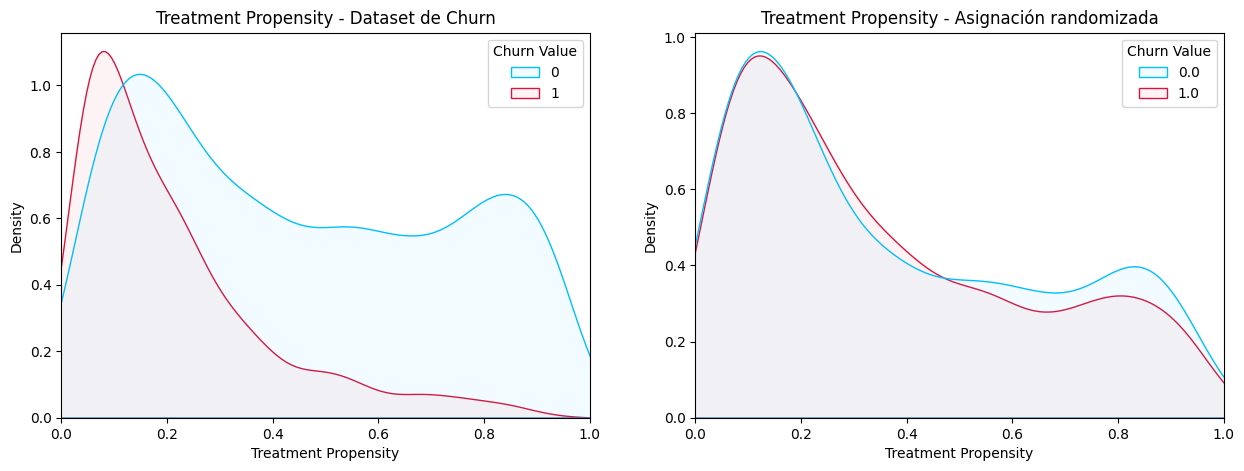

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(data=pd.concat([pd.Series(log_r_t_predict_proba),y.reset_index(drop=True)], axis=1)
            ,x=0
            ,hue='Churn Value'
            ,fill=True
            ,alpha=0.05
            ,palette={0:'deepskyblue',1:'crimson'}
            ,ax=ax1)

sns.kdeplot(data=pd.concat([pd.Series(log_r_t_predict_proba),y], axis=1)
            ,x=0
            ,hue='Churn Value'
            ,fill=True
            ,alpha=0.05
            ,palette={0:'deepskyblue',1:'crimson'}
            ,ax=ax2)

ax1.set_xlim(0,1)
ax1.set_title('Treatment Propensity - Dataset de Churn')
ax1.set_xlabel('Treatment Propensity')
ax2.set_xlim(0,1)
ax2.set_title('Treatment Propensity - Asignación randomizada')
ax2.set_xlabel('Treatment Propensity')
plt.show()

En este caso podemos notar una clara desproporción de los datos en su estado actual (gráfico de la derecha). Cabe recalcar que esto parece lógico en el sentido de que, si se cuenta actualmente con un servicio premium que mejora la calidad de lo que recibe el cliente y si además ese servicio ayuda a solucionar problemas ténicos que el mismo tenga de manera más veloz, suena normal que quienes más propención a tener dicho tratamiento tengan, muesten una distribución más uniforme. En cambio, quienes se han fugado parecen haber tenido menos probabilidades de poseer ese servicio premium.

El gráfico de la derecha, al contrario que el anteriormente comentado, si tiene una distribución más uniforme de ambos grupos (fugados y no fugados). Esto es debido a que para generar dicho gráfico de densidad no se ordenó el propensity score del treatment correctamente, por lo que se asignó en un orden randomizado. Esto básicamente muestra que en un experimento más random, en donde la propención a recibir el tratamiento sea equitativa, estaríamos mitigando un sesgo importante, el de selección.

A continuación, se verán herramientas para mitigar efectivamente dicho sesgo.

### 2. Mitigación de sesgo de selección: Matching

Siguiendo con la librería CausalInference, haremos uso de la herramienta de matching que ofrece. Básicamente se centra en seleccionar pares de instancias que tengan características similares de los diferentes grupos y comparar el outcome resultante de cada una de ellas. También suele utilizar un recorte de los datos, para medir grupos en igualdad de condiciones.

No se profundizará mucho en esta técnica debido a que ha quedado un poco obsoleta y puede mantener ciertos sesgos. Su efectividad mostrada no es de lo mejor, y sobre todo debido a que a continuación veremos una técnica aún más efectiva y bastante más utilizada.

Aún así, la librería ofrece una manera de realizar este matchin en muy pocas líneas de código, por lo que se dejará reflejado aquí.

In [107]:
%%time
causal.est_propensity_s()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      2.104      0.743      2.830      0.005      0.647      3.561
            X3      0.711      0.061     11.666      0.000      0.591      0.830
            X9     -3.976      0.208    -19.136      0.000     -4.383     -3.568
            X1      2.265      0.111     20.431      0.000      2.048      2.483
            X8     -2.343      0.214    -10.937      0.000     -2.763     -1.923
            X5     -0.629      0.135     -4.675      0.000     -0.893     -0.365
            X4     13.251      4.671      2.837      0.005      4.095     22.407
           X12     -0.101      0.141     -0.719      0.472     -0.377      0.175
           X11     -0.190      0.121     -1.567      0.117     -0.428      0.048
           X10     -0.232      0.107     -2.176      0.030     -0.

In [108]:
causal.trim_s()
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=1951)        Treated (N_t=1419)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.344        0.475        0.159        0.366       -0.185

                      Controls (N_c=1951)        Treated (N_t=1419)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.101        0.938        0.431        0.938        0.567
             X1       -0.064        1.084        0.164        1.073        0.211
             X2       -0.041        1.007        0.171        0.944        0.218
             X3        0.412        0.656        0.992        0.830        0.776
             X4        0.322        0.128        0.280        0.118       -0.341
      

Se puede notar como, una vez realizado el matching, las diferencias entre los grupos se han achicado efectivamente.

In [111]:
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.082      0.024     -3.459      0.001     -0.128     -0.035
           ATC     -0.108      0.027     -4.026      0.000     -0.161     -0.056
           ATT     -0.045      0.029     -1.562      0.118     -0.102      0.012



Una vez mitigado dicho sesgo, se puede notar como el ATE es algo superior al obtenido con anterioridad.

## Inverse Propensity Weighting

Este método es actualmente el que más efectividad y uso tiene para calcular el ATE mientras se mitigan los sesgos dentro de las técnicas de propensity score. Básicamente se centra en asignar un peso relativo a cada instancia en sentido opuesto al propensity score del treatment calculado. Asignando este tipo de pesos básicamente se busca conseguir como resultado una población en donde el tratamiento hubiese sido asignado de manera randomizada.

Entonces, asignando pesos con la fórmula $w = \frac{P(T=t)}{P(T=t|X)}$ con la finalidad de crear una muestra en donde se simula que todos hubiesen recibido el tratamiento.

Esto cobra lógica si se piensa que, quienes han sido tratados pero tienen características que hacen que su propención a ser tratados sea muy baja, básicamente se parecerían a lo que hubiese pasado con una instancia no tratada, en caso de que si lo hubiese sido. Es decir, algo parecido a un counterfactual.

Suena complejo, pero probablemente con el ejemplo práctico se comprenda mejor:

Lo primero a realizar es otro modelo de predicción cuyos resultados se utilizarán con el modelo de propención al tratamiento ya calculado. En este caso el modelo será para calcular el target, y para este se volvera a usar una regresión logística.

In [25]:
log_r_y = LogisticRegression()

log_r_y.fit(X_t, y)

log_r_y_predict_proba = log_r_y.predict_proba(X_t)[:,1]

Ya con los modelos listos, se genera un dataset auxiliar en donde se ubican la propención de cada variable y sus valores originales:

In [26]:
df_propensity = pd.concat([pd.Series(log_r_t_predict_proba), pd.Series(log_r_y_predict_proba), y.reset_index(drop=True), X_t['Tech Support'].reset_index(drop=True)], axis=1)
df_propensity.columns = ['propensity_score', 'churn_score', 'Churn Value', 'Tech Support']

In [27]:
df_propensity

,propensity_score,churn_score,Churn Value,Tech Support
0,0.025317,0.758787,0,0.0
1,0.175218,0.047403,0,0.0
2,0.842838,0.155047,0,0.0
3,0.266599,0.363915,1,0.0
4,0.797678,0.030631,0,1.0
...,...,...,...,...
4408,0.084423,0.564745,1,0.0
4409,0.885714,0.006776,0,1.0
4410,0.230477,0.546009,0,0.0
4411,0.166681,0.182616,0,0.0


Una vez se tienen listos los inputs, se aplican los cálculos para reasignar los pesos al dataset:

In [28]:
p_of_t = t.mean() # probabilidad media de tratamiento

t1 = df_propensity[df_propensity['Tech Support']==1] # subgrupo de tratamiento
t0 = df_propensity[df_propensity['Tech Support']==0] # subgrupo de control

weight_t_stable = p_of_t/t1['propensity_score'] # cálculo de los pesos para el grupo tratado
weight_nt_stable = (1-p_of_t)/(1-t0['propensity_score']) # cálculo de los pesos para el grupo control

print("Treat size:", len(t1)) # tamaño del grupo tratado
print("W treat", sum(weight_t_stable)) # suma de los pesos del grupo tratado

print("Control size:", len(t0)) # tamaño del grupo control
print("W treat", sum(weight_nt_stable)) # suma de los pesos del grupo control

Treat size: 1635
W treat 1560.9678519372274
Control size: 2778
W treat 2733.8298319580176


Una vez obtenidos los pesos aplicando la fórmula y verificado que la suma de los mismos tienen un tamaño similar al original, se procede a calcular el ATE con dicho sesgo mitigado:

In [29]:
nt = len(t1)
nc = len(t0)

y1 = sum(t1["churn_score"]*weight_t_stable)/nt # cálculo del promedio ponderado del grupo tratado
y0 = sum(t0["churn_score"]*weight_nt_stable)/nc # cálculo del promedio ponderado del grupo control

print("Weighted ATE: ", y1 - y0) # el ATE es la diferencia entre ambos grupos

Weighted ATE:  -0.09947331168315549


Como se puede observar, el ATE parece ser nuevamente algo mayor al calculado originalmente una vez mitigado el sesgo, aunque manteniéndose en valores razonables, ni tan influyente como para cambiar el rumbo de un cliente propenso a la fuga por completo, pero tampoco tan insignificante como para no tenerlo en cuenta como un posible valor que mitigue esa propención a la fuga.

Finalmente, se procede a mostrar de manera gráfica como ha cambiado la distribución de los grupos una vez que se asignan los pesos a la muestra y se calcula el nuevo ATE con dicho resultado:

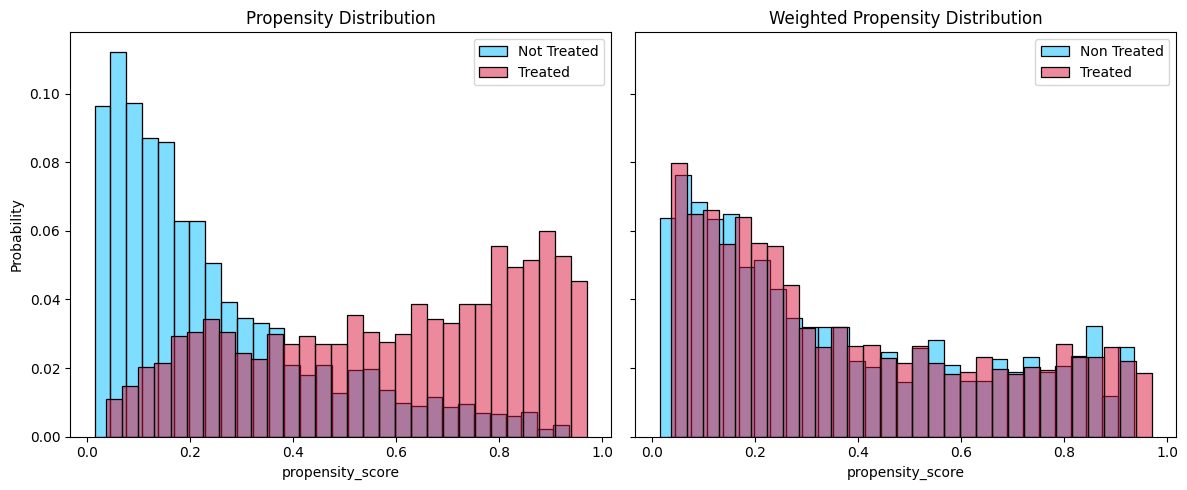

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

sns.histplot(df_propensity[df_propensity['Tech Support']==0]['propensity_score']
            ,stat="probability"
            ,label="Not Treated"
            ,color="deepskyblue"
            ,bins=30
            ,ax=ax1
            ,alpha=0.5)

sns.histplot(df_propensity[df_propensity['Tech Support']==1]['propensity_score']
            ,stat="probability"
            ,label="Treated"
            ,color="crimson"
            ,alpha=0.5
            ,bins=30
            ,ax=ax1)

ax1.set_title("Propensity Distribution")
ax1.legend()

sns.histplot(df_propensity[df_propensity['Tech Support']==0].assign(w=weight_nt_stable)
            ,x="propensity_score"
            ,stat="probability"
            ,color="deepskyblue"
            ,weights="w"
            ,label="Non Treated"
            ,bins=30
            ,ax=ax2
            ,alpha=0.5)

sns.histplot(df_propensity[df_propensity['Tech Support']==1].assign(w=weight_t_stable)
            ,x="propensity_score"
            ,stat="probability"
            ,color="crimson"
            ,weights="w"
            ,label="Treated"
            ,bins=30
            ,alpha=0.5
            ,ax=ax2)

ax2.set_title("Weighted Propensity Distribution")
ax2.legend()

plt.tight_layout()
plt.show()

Como se puede apreciar, es muy notoria la mejoría en cuanto a la homogeneización de los grupos, haciendolos totalmente comparables ahora si.

Como dato de color, se ha de mencionar que, a pesar de ser ambas dos posiblemente de las técnicas más utilizadas en la inferencia causal, el uso de la ortogonalización suele asociarse más a casos de uso con variables continuas, mientras que el propensity score se asocia de mejor manera a casos de uso de clasificación. Esto es en parte debido a la naturaleza de la solución, una más asociada a la regresión y otro a modelos de clasificación, aunque ambos métodos son utilizados hasta de manera conjunta en muchos casos.

# **2. Descubrimiento Causal**

En esta segunda instancia se buscará dar contexto y ahondar sobre las relaciones causales que conforman a nuestro dataset. No es algo escencial para el desarrollo del modelado, es decir, podría pasarse de la etapa 1 a la 3, pero se considera un tema importante a mostrar y que permite, además de dar un mayor entendimiento de las relaciones entre las variables y de exponer nuevas herramientas, hacer de nexo entre el paso 1 de las bases e identificación, al paso 3 en donde directamente se utilizan modelos causales.

En esta etapa básicamente se introduciran los Grafos, específicante los DAG (Directed Acyclic Graph) causales como principal herramienta de exposición de estas relaciones, los cuales conformarán el modelo causal a utilizar. También es aquí en donde se introduce a las principales librerías de análisis causal de código abierto a día de hoy, las cuales forman parte de un mismo ecosistema creado por Microsoft: PyWhy.

PyWhy se compone de 3 librerías principales, interconectadas entre ellas pero cada una enfocada principalmente a una parte específica del análisis causal. Mientras Causal-Learn es la que se enfoca mayoritariamente al descubrimiento causal y a la generación de grafos causales, DoWhy utiliza sus resultados como inputs para generar tanto identificaciones de efectos causales como algunos otros análisis. Finalmente, EconML es la librería enfocada en la aplicación de Modelos Causales al uso.

Otras librerías interesantes a mencionar son CausalNex en cuanto a descubrimiento causal y redes bayesianas (otro de los enfoques posibles, que por el alcance del trabajo quedará dentro del apartado de futuros pasos), CausalML que también se enfoca más en el modelado y CausaLens, librería que abarca todo el proceso pero que de momento no es open source, sino que se requiere de licencias costosas para hacer uso de todo su ecosistema.

## Creación de un Causal DAG usando Causal-Learn

Lo primero que tendremos que hacer para generar el grafo causal será volver a unir X e y en un solo dataframe para poder calcular también las relaciones con el target:

In [9]:
df = pd.concat([X_t, y], axis=1)

La primer alternativa para generar un grafo causal es mediante el llamado Domain Knowledge, es decir, el conocimiento de negocio. Básicamente se trata de utilizar el conocimiento de expertos en el área del negocio para determinar las relaciones entre las variables con sus direccionalidades. Este es por lo general, al menos el primer paso en el proceso, ya que quienes conocen realmente el problema serán quienes puedan determinar las reglas mediante las cuales parece funcionar el el sistema.

Además de tener una clara desventaja de incertidumbre en muchos casos, como en este, en donde no se tiene un conocimiento extenso sobre los datos a tratar y no se cuenta con expertos a los cuales consultar, ante datasets con muchas variables, esto puede tornarse bastante complejo. Por ende, a pesar de ser la primera opción y algo recomendable al menos para setear ciertos lineamientos de base, parece necesario el agregar métodos estadísticos que permitan moldear dichas relaciones.

En este aspecto la verdad es que existen varias alternativas en donde las relaciones se calculan de diferentes maneras. De entre una amplia cantidad de métodos que existen se podrían dividir entre los basados en restricciones (constraint-based) y los basados en scoring. No está dentro del alcance del TFM el profundizar en estos métodos matemáticos.

El modelo que se ha elegido para utilizar en este caso es el LiNGAM, uno de los métodos recomendado en DoWhy para cuando el grafo que se necesita generar es un DAG, el cual en este caso ha dado buenos resultados:

In [32]:
labels = [f'{col}' for i, col in enumerate(df.columns)] # genero etiquetas con los nombres de las variables
data = df.to_numpy()

graph_model = lingam.ICALiNGAM() # instancio el modelo de lingam
graph_model.fit(data) # entreno el modelo con el dataset para generar el grafo causal

Una vez creado el modelo, se utiliza una función personalizada para crear el grafo y plotearlo:

In [33]:
adjacency_matrix = graph_model.adjacency_matrix_.copy()
adjacency_matrix[abs(adjacency_matrix) < 0.05] = 0
fr.make_graph(adjacency_matrix, labels=labels)
plt.show()

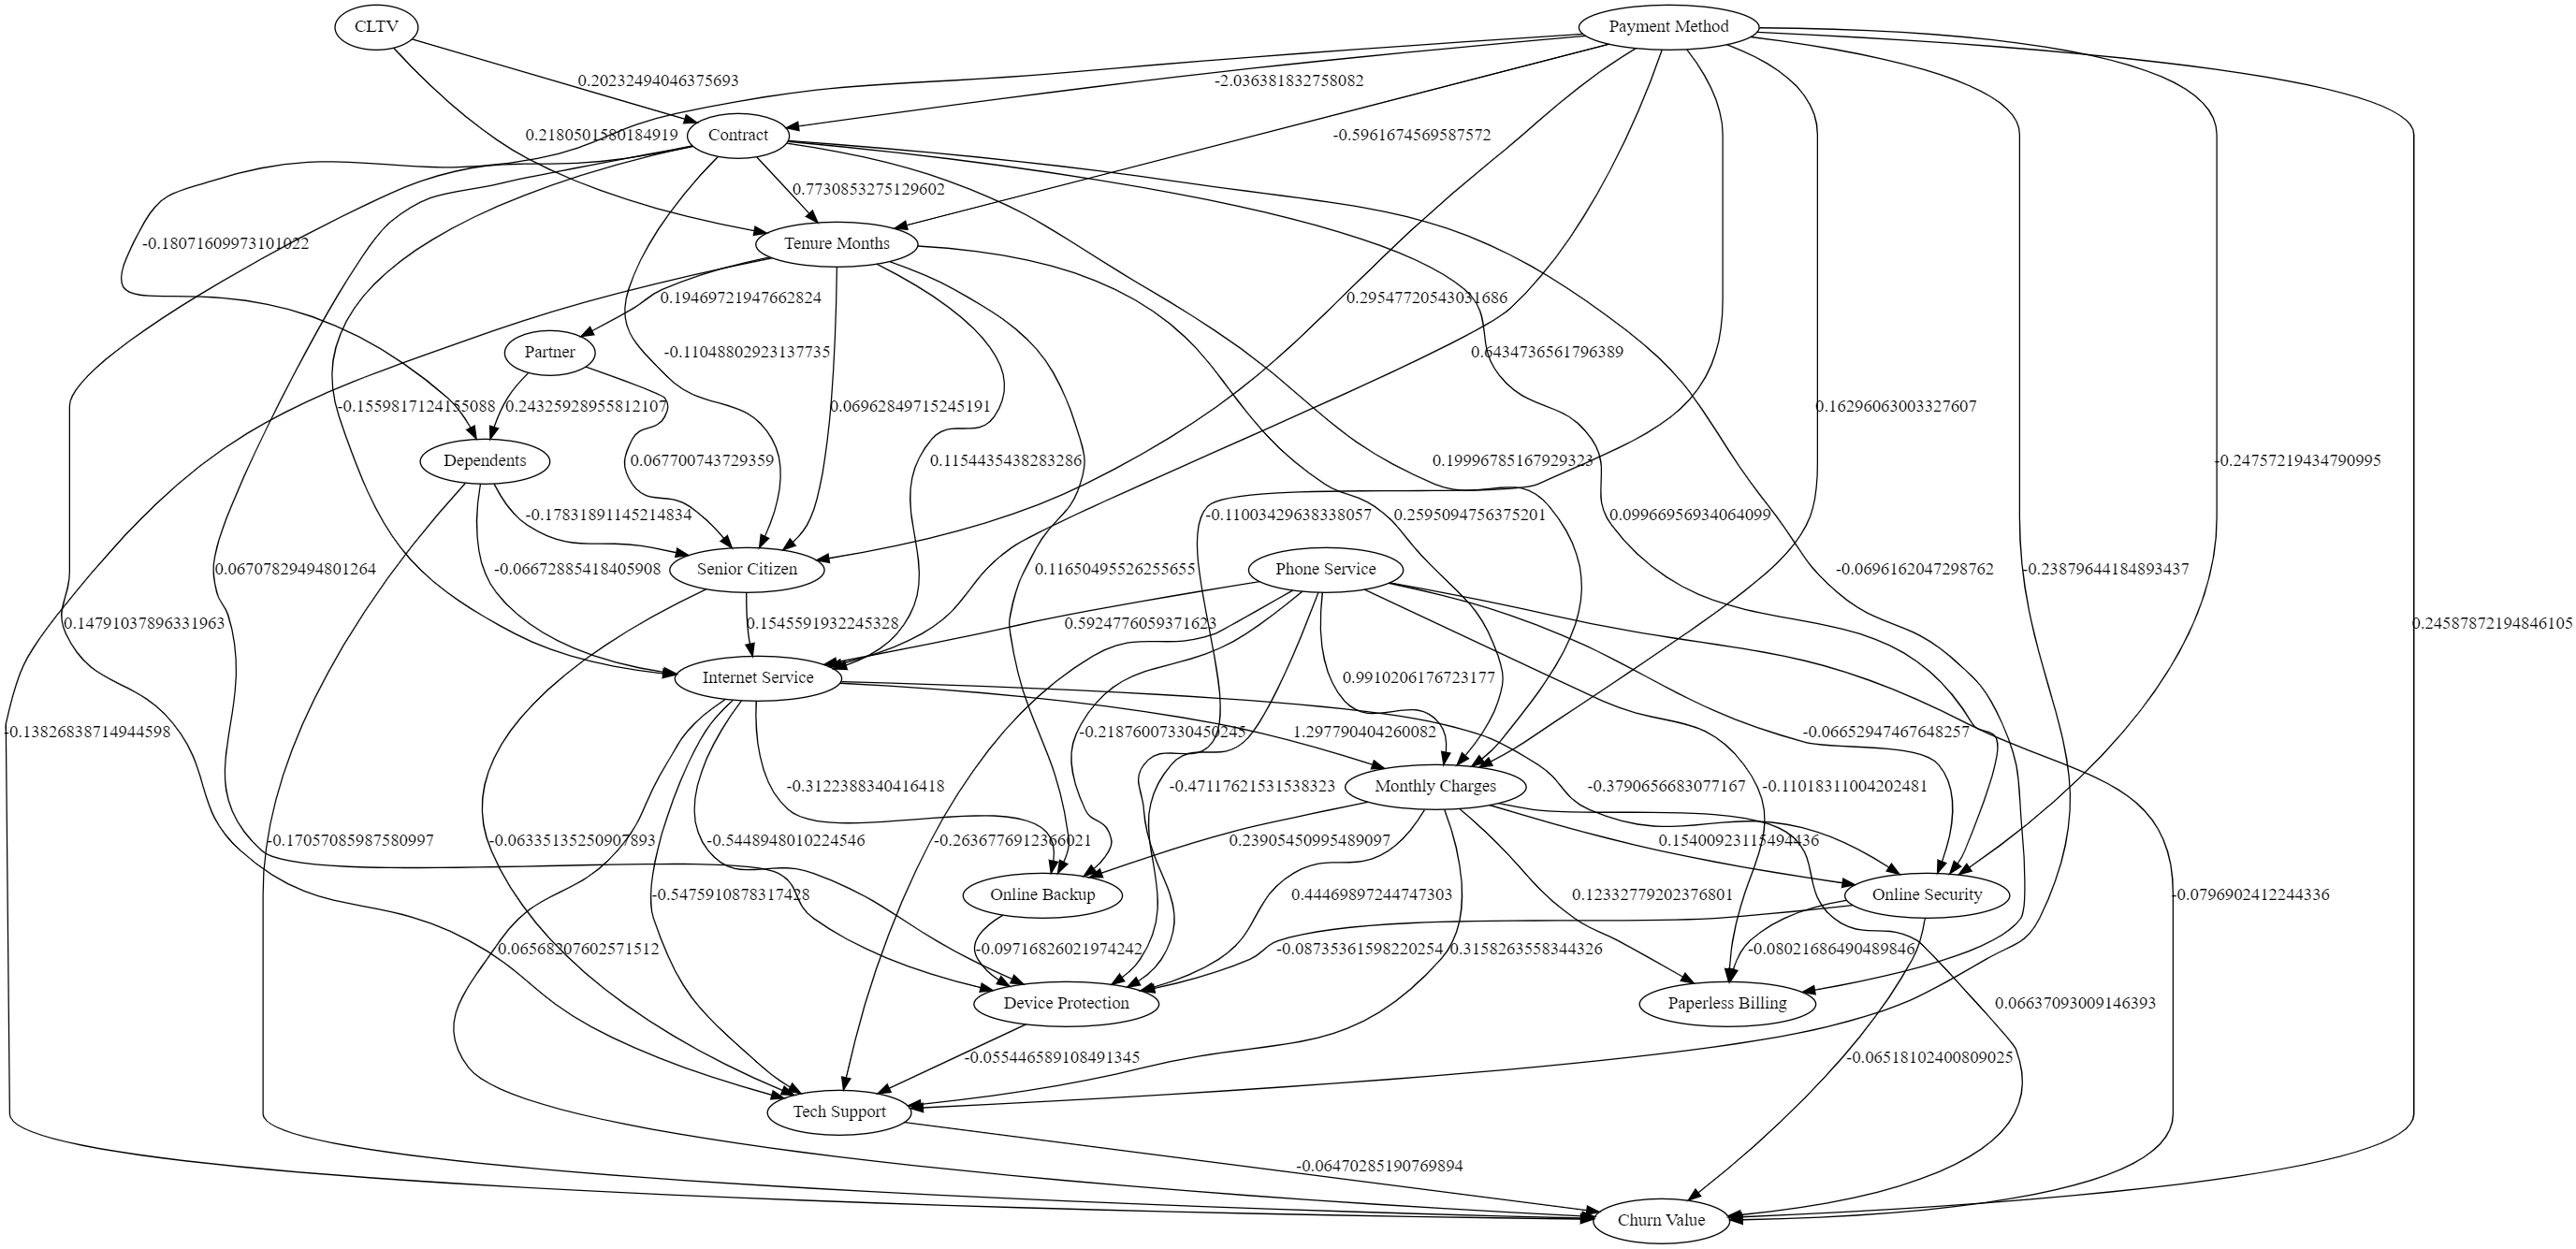

Como se puede apreciar, se trata de un grafo dirigido y cuyo final es en la variable target, siendo el treatment una de las principales variables relacionadas. La precisión es realmente sorprendente al pensar que sólo se asignó como input un dataset y el modelo diagramó todo.

Una vez generado el causal DAG, se busca también una manera más visual de representarlo, en este caso introduciendo la librería Pyvis, que en conjunto con networkx permiten generar visualizaciones interactivas de grafos en objetos html.

Para ello, primero es necesario configurar el objeto de nerworkX y luego pasarlo a Pyvis:

In [133]:
# converto graph_model a un grafo de networkx

G = nx.DiGraph()
for i, node in enumerate(labels):
    G.add_node(node)

for i, node in enumerate(labels):
    for j, node2 in enumerate(labels):
        if adjacency_matrix[i,j] != 0:
            G.add_edge(node, node2)

# agrego los pesos de los ejes:

for i, node in enumerate(labels):
    for j, node2 in enumerate(labels):
        if adjacency_matrix[i,j] != 0:
            G[node][node2]['weight'] = adjacency_matrix[i,j]

Se genera el objeto network en Pyvis y se lo relaciona al grafo de networkx:

In [156]:
net = Network(notebook=True
             ,select_menu=True
             ,filter_menu=True)

In [157]:
net.from_nx(G)

Se agregan algunos parametros extra a la visualización:

In [158]:
# Distancia entre los nodos:
net.repulsion(node_distance=100, spring_length=500)
# Color diferente a los nodos de tratamiento y outcome:
for node in net.nodes:
    if node['label'] == 'Tech Support':
        node['color'] = 'deepskyblue'
    if node['label'] == 'Churn Value':
        node['color'] = 'gold'

# Opciones interactivas configurables:
#net.show_buttons(filter_="physics")

In [159]:
# Guardamos el gráfico en un archivo HTML:
net.save_graph('CausalDAG.html')

In [160]:
net.show('CausalDAG.html')

CausalDAG.html


Es probable que si la lectura se está realizando en un notebook o si no se cuenta con el archivo .html del grafo en esta misma carpeta, no se visualice correctamente el objeto interactivo. Es por ello que se agrega también una imagen estática del resultado de dicha visualización:
<div align="center">
  <img src="../images/Causal-DAG-Pyvis.png">
</div>

## Estimaciones causales: DoWhy

Una vez configurado el grafo causal, es posible crear un modelo causal estuctural con DoWhy partiendo de este DAG, de la siguiente manera:

In [34]:
graph_dot = fr.make_graph(graph_model.adjacency_matrix_, labels=labels)

causal_model = CausalModel(
        data = df,
        treatment='Tech Support',
        outcome='Churn Value',
        graph=fr.str_to_dot(graph_dot.source)
        )

A continuación se procede a realizar una identificación causal al igual que antes, es decir, a calcular el ATE nuevamente utilizando este nuevo modelo causal.

En este caso se utiliza la regresión logística para calcularlo mediante el método de la puerta trasera en el DAG. Además, de ahora en más en estos modelos causales veremos que, además de calcular el ATE, es posible obtener el intervalo de confianza que lo contenga, para estar aún más seguros de nuestra estimación, algo de gran utilidad por varias razones, pero principalmente debido a que se trata de un valor desconocido y por el dilema de los counterfactuals, solo aproximable.

In [35]:
# Identificación
identified_estimand_binary = causal_model.identify_effect(proceed_when_unidentifiable=True)

# Estimación lineal
estimate = causal_model.estimate_effect(identified_estimand_binary,
                                method_name="backdoor.generalized_linear_model",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True,
                                method_params = {
                                            'num_null_simulations':10,
                                            'num_simulations':10,
                                            'num_quantiles_to_discretize_cont_cols':10,
                                            'fit_method': "statsmodels",
                                            'glm_family': statm.families.Binomial(), # logistic regression
                                            'need_conditional_estimates':False,
                                            "fit_params":{
                                                    'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                        }
                                                })

generalized_linear_model
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[Churn Value|Contract,Senior Citizen,Device Protection,Intern
d[Tech Support]                                                               

                                                                              
et Service,Monthly Charges,Online Backup,Payment Method,Phone Service,Partner]
                                                                              

 
)
 
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Churn Value then P(Churn Value|Tech Support,Contract,Senior Citizen,Device Protection,Internet Service,Monthly Charges,Online Backup,Payment Method,Phone Service,Partner,U) = P(Churn Value|Tech Support,Contract,Senior Citizen,Device Protection,Internet Service,Monthly Charges,Onlin

In [48]:
print(f"El efecto causal estimado es: {estimate.value:.4f} con un intervalo de confianza de [{estimate.get_confidence_intervals()[0]:.4f} a {estimate.get_confidence_intervals()[1]:.4f}]")

El efecto causal estimado es: -0.0738 con un intervalo de confianza de [-0.1083 a -0.0628]


Los resultados de la inferencia al utilizar el modelo causal se muestran nuevamente efectivos, no solo dilucidando un valor del ATE muy similar a los conseguidos con anterioridad, sino también otorgándonos un intervalo de confianza del 95%, dentro del cual se abarcan también las estimaciones anteriores.

A esta altura ya es posible confirmar que el ATE verdadero al menos se encontrará dentro de ese intervalo, medido con 3 métodos diferentes, siendo este último modelo además el que llega a un valor intermedio, probablemente lo más cercano al efecto causal real.

No solo es importante llegar a estas confirmaciones mediante el descubrimiento y la identificación causal por tener el número en sí, sino también debido a que estos pasos, además de permitirnos conocer mejor los pormenores de la relación entre las variables, también servirán como base para la siguiente sección, en donde ya no todo es tan preciso, debido a que comenzamos a exigir mucho más a los modelos. Es momento de pasar del cálculo del ATE al cálculo del CATE, y por ende, de introducir de lleno a los principales Modelos Causales de Machine Learning que permiten llegar a esto: los Metalearners.

# **3. Aplicación de modelos causales**

En esta última sección del análisis causal, finalmente se aplicarán los principales modelos de machine learning causal para el cálculo del ATE y CATE.

## Introducción de los modelos causales de machine learning con DoWhy + EconML

Antes de pasar a la librería para la generación de los modelos en sí, parece un buen intermedio el mostrar como con DoWhy se pueden realizar ciertas inferencias utilizando cualquiera de los modelos causales de EconML, ya sean Metalearners u otros para calcular el ATE, en este caso en realidad como la media del CATE.

Aún así, como se verá a continuación, el promedio del CATE no parece ser la mejor estimación del ATE, ya que, a pesar de ser un resultado parecido, parece brindar menos confianza debido a la gran volatilidad que tiene este cálculo. Justamente en los amplios intervalos de confianza que se generarán como resultado de estos cálculos se podrá notar que la volatilidad del estimador se ve aumentada. Es por ello que el ATE se calculará como lo hemos visto y los modelos causales para calcular el CATE tomarán importancia al pensar en la utilidad de negocio que dicha métrica puede obtener, ya que no solo será importante conocer el efecto causal, sino también el poder llevar este análisis a potenciales acciones de negocio para mitigar la propención a fuga de clientes en particular.

Esto es debido a muchos factores, entre ellos a que se depende mucho del nivel de precisión con los que se puedan calcular estimaciones sobre el set de datos, la existencia de overfitting, la calidad y cantidad de los datos, e inherente a todo esto, simplemente la naturaleza del análisis, en donde se búsca particularizar un efecto promedio que ya de por sí es complejo de ser calculado.

Como se comentó en el primer capítulo del trabajo, probablemente el mayor problema y a la vez la razón de ser del modelado causal es la imposibilidad fáctica de conocer que hubiese pasado en dos situaciones opuestas, por ejemplo en este caso, que hubiese pasado con la propención a fuga de el mismo cliente tanto en el caso de recibir o no el tratamiento. Exepto a que se pudiese controlar el tiempo a voluntad o viajar entre universos paralelos, esto es básicamente imposible. Pero los modelos de machine learning nos permiten intentar predecir que hubiese pasado en esas situaciones hipotéticas, por lo que, combinado con las herramientas de mitigación de sesgos del análisis causal, la idea central será intentar calcular de la mejor manera posible estos escenarios posibles y compararlos para obtener un indicador de impacto sobre ello.

Claro que, además de tratarse de una tarea compleja y que depende de muchos factores, el intentar trasladarlo a nivel individual implica una potencial suma de errores alta. Es por esto que, no solo deben ajustarse lo mejor posible los modelos, sino también de deberá tomar de manera relativa los resultados mientras más individualizados sean, aunque los indicadores que se obtengan a nivel de la muestra total o hasta agrupada si puedan ser más confiables.

## Metalearners

Dicho esto, e introduciéndo a los modelos causales en la ecuación, es momento de hablar de los **Metalearners**. Estos básicamente son una mezcla de modelos de machine learning que buscan combinar el análisis de counterfactuals, en donde se calculan los escenarios hipotéticos mencionados con anterioridad tanto para el grupo tratado como el de control con el fin de medir sus diferencias y por ende el efecto causal del tratamiento. Además de ello, por lo general se le agregan métodos propios de la inferencia causal para mejorar estas predicciones y mitigar sesgos, como pueden ser el propensity score y versiones potenciadas de la ortogonalización o teorema FLW. Como resultado de la aplicación de estas mixturas se obtienen los efectos condicionales medios del tratamiento, más conocidos como CATE, que sería el efecto causal del tratamiento para un grupo o instancia en particular.

Entre los muchos metalearners existentes, los más destacados probablemente sean el T-Learner, S-Learner, X-Learner, R-Learner (o DoubleML) y el DR-Learner. Los primeros dos son modelados mucho más simples, que abarcan más bien la primer parte del proceso mencionado anteriormente, es decir, el cálculo y análisis diferencial de los potential outcomes, siendo el T-Learner el metalearner base orientado a problemas binarios o de clasificación y el S-Learner el utilizado para problemas en el que el outcome es continuo.

Tanto el X-Learner como el R-Learner son evoluciones del T-Learner y del S-Learner respectivamente. El primero complejiza a su predecesor, agregándole más modelados de por medio, entre ellos aplicando la técnica del propensity score, logrando así mejorar al T-Learner en varios sentidos, sobre todo reduciendo los sesgos, adaptándolo mejor a predicción de relaciones no lineales y funcionando mejor también cuando existe cierto desbalanceo entre los grupos de tratamiento y control.

Por otro lado, el R-Learner, más conocido como Double Machine Learning, es básicamente una versión potenciada del teorema FLW, ya que utiliza modelos potentes de machine learning para calcular los residuos sin sesgos tanto de la variable treatment como del outcome, para luego aplicar otro modelo predictivo que permita obtener la relación causal sin sesgos, mientras que a su vez también ejecuta una llamada R-Loss function o Causal Loss Function, que permite flexibilidar el cálculo del efecto causal para cada instancia y sus covariables.

Finalmente, el DR-Learner o Doubly Robust Learner sería una versión del DoubleML pero basado en el propensity score, por lo que también utiliza modelos de machine learning para realizar el proceso de eliminación de sesgos y a su vez calcular los potential outcomes que luego darán como resultado al ATE y al CATE.

No es parte del alcance del trabajo el profundizar sobre el funcionamiento interno de cada modelo matemáticamente, pero si parece importante al menos el brindar un pequeño resumen entendible de cada uno de los modelos con los que se trabajará. Además de estos, existen otros y cada vez más modelos causales a tener en cuenta, como los basados en árboles (causal forest), en redes neuronales, entre otros. En este caso nos centraremos solo en los metalearners principales.

## Binary Metalearners: DR-Learner y X-Learner

Debido a que en el caso de uso sobre el que se está trabajando tanto la variable treatment como el target son binarias y por ende se trata de un caso puramente de clasificación, los principales metalearners a utilizar serán el DR-Learner y el X-Learner. A continuación, la primer aproximación a estos, en donde simplemente se realizará una estimación del efecto causal sobre el modelo de DoWhy, utilizando el X-Learner:

In [51]:
%%time
Xlearner_estimate = causal_model.estimate_effect(identified_estimand_binary,
                                method_name="backdoor.econml.metalearners.XLearner",
                                confidence_intervals=True,
                                method_params={"init_params":{
                                                'models': LGBMRegressor(verbose=-1, max_depth=3),
                                                'propensity_model': LGBMClassifier(verbose=-1, max_depth=3)
                                                },
                                        "fit_params":{
                                                        'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                        }
                                                })
print(Xlearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[Churn Value|Contract,Senior Citizen,Device Protection,Intern
d[Tech Support]                                                               

                                                                              
et Service,Monthly Charges,Online Backup,Payment Method,Phone Service,Partner]
                                                                              

 
)
 
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Churn Value then P(Churn Value|Tech Support,Contract,Senior Citizen,Device Protection,Internet Service,Monthly Charges,Online Backup,Payment Method,Phone Service,Partner,U) = P(Churn Value|Tech Support,Contract,Senior Citizen,Device Protection,Internet Service,Monthly Charges,Online Backup,Payment Method,P

In [52]:
Xlearner_estimate.get_confidence_intervals()[0].mean(), Xlearner_estimate.get_confidence_intervals()[1].mean()

Como se puede apreciar, el ATE, que es calculado básicamente como la media de los CATE, parece estar bastante acertado y en línea con los cálculos anteriores, aunque la volatilidad mencionada con anterioridad se puede ver reflejada en el intervalo de confianza de los CATE, en donde ya se logran apreciar valores mucho más alejados.

Es algo con lo que hay que lidiar y es importante recalcar que muchas veces el overfitting puede ser uno de los principales culpables de esto, ya que, luego de realizar una importante cantidad de pruebas, se ha podido notar que mientras menos parámetros de regularización se introduzcan, mucho mayor es el intervalo de confianza. Matheus Facure menciona este peligro en su libro, por lo que es importante medir bien estos parámetros para evitar el overfitting al usar varios modelos uno sobre otro como en estos casos, más aún cuando el dataset es pequeño, como en este caso actual.

Como consecuencia, se notará el uso de varios parámetros de regularización, sobre todo en los modelos de cálculo de los potential outcomes, como max_depth, l1 o l2, con el fin de reducir la volatilidad, aunque manteniendo en la medida de lo posible la capacidad predictiva del modelo.

# Modelos Causales de EconML: Metalearners al uso

Para concluír con el notebook principal del trabajo, finalmente se ejecutará la principal librería para generar modelos causales de todo tipo, EconML. En este caso el uso se hará sobre los principales metalearners mencionados con anterioridad. La ejecución es relativamente simple y recuerda a los modelos tradicionales en el sentido de que se deben instanciar y definir, luego entrenar, y en que son capaces de realizar las estimaciones sobre nuevos sets, en estos casos del CATE y ATE.

### X-Learner

Una constante en este tipo de modelos causales será el hecho de tener que definir los modelos de machine learning al uso que los compondrán, pudiendo elegir prácticamente cualquier modelo que posea los métodos fit, predict y predict_proba en ciertos casos. Por supuesto, queda a criterio del data scientist el modelo a seleccionar para cada caso y sus hiperparámetros.

En este caso en concreto los modelos de cálculo de los potential outcomes serán LightGBM, mientras que el modelo de propensity score elegido será una regresión logística.

In [100]:
xlearner = XLearner(models=LGBMRegressor(verbose=-1, max_depth=3, learning_rate=0.04, lambda_l1=1, lambda_l2=5, random_state=SEED)
                    ,propensity_model=LogisticRegression())

In [101]:
xlearner.fit(Y=y.values, T=X_t['Tech Support'].values, X=X_t.drop('Tech Support', axis=1).values, inference="bootstrap")

Una vez entrenado el modelo, lo primero que se realiza es guardar la estimación del CATE para cada instancia, lo que luego nos permitirá medir y compararlo con los demás modelos causales.

In [102]:
cates_train = xlearner.effect(X_t.drop('Tech Support', axis=1).values)

In [103]:
pd.Series(cates_train).describe()

count    4413.000000
mean       -0.072020
std         0.069473
min        -0.272919
25%        -0.121061
50%        -0.066006
75%        -0.016126
max         0.117661
dtype: float64

Además, tenemos la posibilidad de conocer tanto el ATE como el intervalo de confianza generado:

In [104]:
xlearner.ate(X_t.drop('Tech Support', axis=1).values)

El resultado es sorprendentemente similar a lo visto con anterioridad, lo cual es una muy buena señal, aunque el intervalo de confianza sigue siendo bastante amplio:

In [105]:
xlearner.ate_interval(X_t.drop('Tech Support', axis=1).values)

In [106]:
xlearner.effect_interval(X_t.drop('Tech Support', axis=1).values, alpha=0.05)[0].mean(), xlearner.effect_interval(X_t.drop('Tech Support', axis=1).values, alpha=0.05)[1].mean()

### Doubly Robust Learner

Aplicamos el mismo procedimiento al segundo modelo causal específico de clasificación: DR-Learner.

In [87]:
drl = LinearDRLearner(model_propensity=LogisticRegression()
                ,model_regression=LGBMRegressor(verbose=-1, max_depth=3, learning_rate=0.04, lambda_l1=1, lambda_l2=5, random_state=SEED))

In [88]:
drl.fit(Y=y.values, T=X_t['Tech Support'].values, X=X_t.drop('Tech Support', axis=1).values, inference="bootstrap")

In [89]:
drl.ate(X_t.drop('Tech Support', axis=1).values)

In [90]:
drl.ate_interval(X_t.drop('Tech Support', axis=1).values)

In [91]:
cates_drl = drl.effect(X_t.drop('Tech Support', axis=1).values)

Se puede apreciar que los resultados son muy similares al X-Learner, por lo que decidir entre ambos a simple vista no es algo sencillo. A continuación se aplicará una ingeniosa téncica para medir de manera relativa cada modelo, nuevamente referencia de Matheus Facure.

### R-Learner / Double-ML

Finalmente y a modo de prueba se genera también otro de los principales modelos causales, el R-Learner o Double ML, aunque los resultados esperados no sean los mejores debido a que es un modelo mucho más orientado a casos de uso de resultados numéricos continuos.

In [92]:
dml = DML(model_y=LGBMRegressor(verbose=-1, max_depth=3, learning_rate=0.04, lambda_l1=1, lambda_l2=5, random_state=SEED)
         ,model_t=LGBMRegressor(verbose=-1, max_depth=3, learning_rate=0.04, lambda_l1=1, lambda_l2=5, random_state=SEED)
         ,model_final=LGBMRegressor(verbose=-1, max_depth=3, learning_rate=0.04, lambda_l1=1, lambda_l2=5, random_state=SEED)
         )

In [93]:
dml.fit(Y=y.values, T=X_t['Tech Support'].values, X=X_t.drop('Tech Support', axis=1).values, inference="bootstrap")

In [95]:
dml.ate(X_t.drop('Tech Support', axis=1).values)

In [96]:
dml.ate_interval(X_t.drop('Tech Support', axis=1).values)

In [97]:
cates_dml = dml.effect(X_t.drop('Tech Support', axis=1).values)

In [98]:
pd.Series(cates_dml).describe()

count    4413.000000
mean       -0.056659
std         0.027108
min        -0.159622
25%        -0.074417
50%        -0.055614
75%        -0.036705
max         0.018334
dtype: float64

Como es posible apreciar, los resultados ya a simple vista no parecen ser tan buenos como los anteriores.

## Medición del modelado causal y comparativa de modelos

En el mundo del análisis causal el medir los resultados parecer ser algo mucho más complejo que a lo que se acostumbra con los modelos predictivos supervisados. Mientras que para estos últimos se poseen datos exactos contra los que medir el resultado del modelo, el dato real de un análisis causal, como se comentó ya en varias ocaciones, es fácticamente imposible de conseguir, por lo que es necesario recurrir a métodos más originales. Por lo general al desarrollar este tipo de estudios se utilizan datos sintéticos, por lo que se puede llegar a conocer el ATE real (ya que es creado por el propio investigador), pero justamente la idea de este caso es intentar probar estos modelos sobre datos públicos de casos reales.

Lamentablemente no es mucha la bibliografía al respecto de momento, pero Matheus Facure plantea una idea muy interesante, en la que se aplica una especie de curva de ganancia, a la que también llama curva de sensibilidad, que permite medir en cierta manera que tan bien es capaz de distribuír el modelo los CATE generados de manera lógica. Este análisis permite obtener un área bajo dichas curvas, la cual finalmente sirve de métrica principal de medición relativa entre los modelos causales.

Debido a que el objetivo del data scientist en estos casos surge es entender que individuos son más o menos sensibles al tratamiento, para de esta manera aplicarlo de la manera más eficiente posible, se puede decir que la base de este análisis se centra principalmente en medir que tan bien logrará personalizar el modelo la estimación del CATE, es decir, que tan bien es capaz de distribuír de manera lógica la propención entre los individuos.

Como ya se ha comentado, el medir los registros de manera individual puede ser complejo debido a que, con los modelos actuales y sus amplios intervalos de confianza, el error puede ser muy grande, pero como se ha podido observar, las mediciones cuando se llevan al general si se acercan mucho al valor correcto del ATE, por lo que un buen intermedio puede ser el medir por grupos la distribución del CATE, por ejemplo en cuantiles.

Lo primero que se realizará será medir el efecto o sensibilidad general del tratamiento como si no existiesen otras variables, que es básicamente la comparación entre los grupos de tratamiento y control, cuya función se detalla a continuación:

In [107]:
@curry
def effect(data, y, t):
        return (np.sum((data[t] - data[t].mean())*data[y]) /
                np.sum((data[t] - data[t].mean())**2))

In [108]:
effect(df, y="Churn Value", t="Tech Support")

Como curiosidad, esto sería similar a correr una regresión lineal en la que la variable tratamiento prediga a la variable target y obtener el coeficiente:

In [24]:
linear_r = LinearRegression()

linear_r.fit(X_t['Tech Support'].values.reshape(-1,1), y)

linear_r.coef_

array([-0.267])

Ya con el efecto general calculado, se procede a calcular la curva para el efecto particular:

In [109]:
df_cgc = pd.concat([X_t['Tech Support'].reset_index(drop=True)
                    ,y.reset_index(drop=True)
                    ,pd.Series(cates_train)
                    ,pd.Series(cates_drl)
                    ,pd.Series(cates_dml)
                    ], axis=1)

In [110]:
df_cgc.rename(columns={0:'cates xlearner', 1:'cates drlearner', 2:'cates dml'}, inplace=True)

In [111]:
df_cgc

,Tech Support,Churn Value,cates xlearner,cates drlearner,cates dml
0,0.0,0,-0.199732,-0.133898,-0.043198
1,0.0,0,-0.080580,-0.129900,-0.088136
2,0.0,0,0.039262,0.021940,-0.055432
3,0.0,1,-0.140620,-0.244876,-0.044024
4,1.0,0,0.099343,0.083115,-0.033281
...,...,...,...,...,...
4408,0.0,1,-0.053172,-0.101893,-0.035917
4409,1.0,0,0.022734,0.050988,-0.080401
4410,0.0,0,-0.103114,-0.135879,0.002066
4411,0.0,0,-0.046212,-0.071898,-0.061950


In [112]:
def cumulative_gain_curve2(df, prediction, y, t,
                          ascending=False, normalize=False, steps=100):
    
    effect_fn = effect(t=t, y=y)
    normalizer = effect_fn(df) if normalize else 0
    
    size = len(df)
    ordered_df = (df
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size/steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index<={row}"))
                -normalizer)*(row/size) 
               for row in steps]

    return np.array([0] + effects)

Utilizando la función de la librería fklearn (autoría de Matheus) se calcula la curva de ganancia / sensibilidad:

In [113]:
cumu_gain_xl = cumulative_gain_curve(df=df_cgc
                                    ,outcome='Churn Value'
                                    ,treatment='Tech Support'
                                    ,prediction='cates xlearner'
                                    )

cumu_gain_drl = cumulative_gain_curve(df=df_cgc
                                    ,outcome='Churn Value'
                                    ,treatment='Tech Support'
                                    ,prediction='cates drlearner'
                                    )

cumu_gain_dml = cumulative_gain_curve(df=df_cgc
                                    ,outcome='Churn Value'
                                    ,treatment='Tech Support'
                                    ,prediction='cates dml'
                                    )

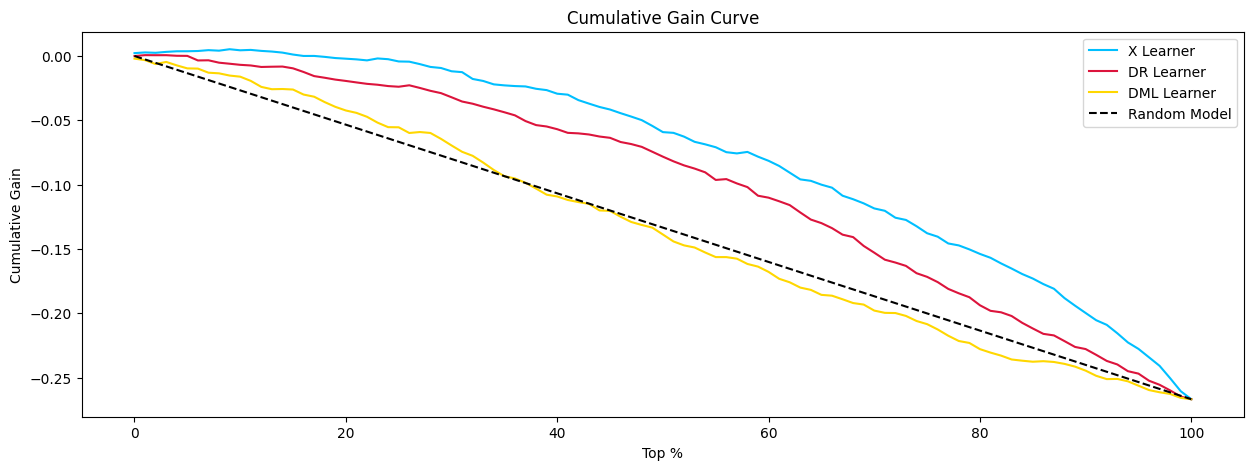

In [114]:
fig, ax1 = plt.subplots(figsize=(15,5))

x = np.array(range(len(cumu_gain_xl)))
ax1.plot(100*(x/x.max()), cumu_gain_xl, label='X Learner', color='deepskyblue')
ax1.plot(100*(x/x.max()), cumu_gain_drl, label='DR Learner', color='crimson')
ax1.plot(100*(x/x.max()), cumu_gain_dml, label='DML Learner', color='gold')
    
ax1.plot([0, 100], [0, effect(df, y="Churn Value", t="Tech Support")], linestyle="--", label="Random Model", color="black")

ax1.set_xlabel("Top %")
ax1.set_ylabel("Cumulative Gain")
ax1.set_title("Cumulative Gain Curve")
ax1.legend()
plt.show()

La idea de la curva es similar a la de los modelos predictivos: Mientras que un cálculo totalmente random requiere del total del dataset ordenado para predecirr correctamente el efecto o la sensibilidad en este caso, mientras mayor sea el área de los modelos por sobre dicha línea randomizada, mejor estarán prediciendo el CATE con menor porcentaje del dataset.

In [115]:
cumu_gain_xl_n = cumulative_gain_curve2(df=df_cgc
                                 ,y='Churn Value'
                                 ,t='Tech Support'
                                 ,prediction='cates xlearner'
                                 ,normalize=True
                                 )
cumu_gain_drl_n = cumulative_gain_curve2(df=df_cgc
                                 ,y='Churn Value'
                                 ,t='Tech Support'
                                 ,prediction='cates drlearner'
                                 ,normalize=True
                                 )

cumu_gain_dml_n = cumulative_gain_curve2(df=df_cgc
                                 ,y='Churn Value'
                                 ,t='Tech Support'
                                 ,prediction='cates dml'
                                 ,normalize=True
                                 )

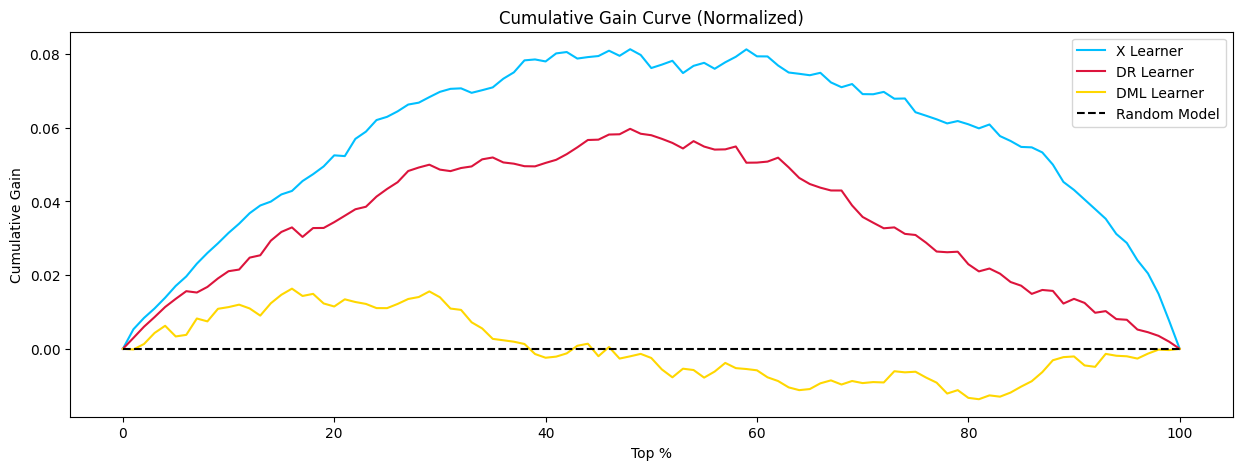

In [116]:
fig, ax2 = plt.subplots(figsize=(15,5))

x = np.array(range(len(cumu_gain_xl)))
ax2.plot(100*(x/x.max()), cumu_gain_xl_n, label='X Learner', color='deepskyblue')
ax2.plot(100*(x/x.max()), cumu_gain_drl_n, label='DR Learner', color='crimson')
ax2.plot(100*(x/x.max()), cumu_gain_dml_n, label='DML Learner', color='gold')
    
ax2.hlines(0, 0, 100, linestyle="--", label="Random Model", color="black")

ax2.set_xlabel("Top %")
ax2.set_ylabel("Cumulative Gain")
ax2.set_title("Cumulative Gain Curve (Normalized)")
ax2.legend()
plt.show()

In [117]:
auc_cec(df=df_cgc
        ,outcome='Churn Value'
        ,treatment='Tech Support'
        ,prediction='cates xlearner')

In [118]:
dic = {'X Learner':'cates xlearner', 'DR Learner':'cates drlearner', 'DML Learner':'cates dml'}
for i in dic:
    auc = auc_cec(df=df_cgc
                 ,outcome='Churn Value'
                 ,treatment='Tech Support'
                 ,prediction=dic[i])
    print(f'AUC de {i}: {auc}')

AUC de X Learner: 0.17025970308128538
AUC de DR Learner: 0.11156703087993333
AUC de DML Learner: 0.019001560437164177


In [119]:
def effect_by_quantile(df, pred, y, t, q=10):
    
    # makes quantile partitions
    groups = np.round(pd.IntervalIndex(pd.qcut(df[pred], q=q)).mid, 2) 
    
    return (df
            .assign(**{f"{pred}_quantile": groups})
            .groupby(f"{pred}_quantile")
            # estimate the effect on each quantile
            .apply(effect(y=y, t=t))) 


effect_by_quantile(df_cgc, "cates xlearner", y="Churn Value", t="Tech Support")

cates xlearner_quantile
-0.22   -0.601212
-0.15   -0.338905
-0.12   -0.215367
-0.10   -0.266509
-0.08   -0.121955
-0.06   -0.142624
-0.04   -0.114458
-0.02   -0.054008
 0.00   -0.040156
 0.07    0.048028
dtype: float64

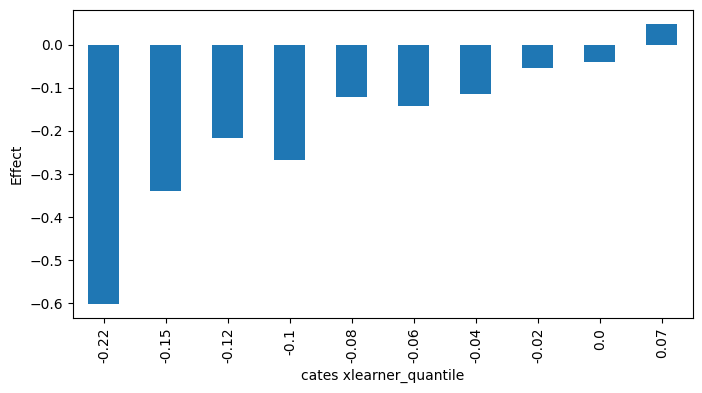

In [120]:
fig, ax = plt.subplots(figsize=(8, 4))
effect_by_quantile(df_cgc, "cates xlearner", y="Churn Value", t="Tech Support").plot.bar(ax=ax)
ax.set_ylabel("Effect")
plt.show()

In [121]:
def cumulative_effect_curve(dataset, prediction, y, t,
                            ascending=False, steps=100):
    size = len(dataset)
    ordered_df = (dataset
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size/steps, size, steps).round(0)
    
    return np.array([effect(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in steps])

cumulative_effect_curve(df_cgc, "cates xlearner", y="Churn Value", t="Tech Support")

array([ 0.267,  0.154,  0.1  ,  0.079,  0.074,  0.06 ,  0.063,  0.058,
        0.052,  0.048,  0.042,  0.04 ,  0.032,  0.019,  0.013,  0.001,
        0.001, -0.003, -0.006, -0.004, -0.018, -0.008, -0.01 , -0.008,
       -0.015, -0.019, -0.021, -0.028, -0.031, -0.034, -0.039, -0.046,
       -0.056, -0.06 , -0.064, -0.063, -0.064, -0.061, -0.065, -0.072,
       -0.071, -0.075, -0.084, -0.087, -0.09 , -0.091, -0.098, -0.097,
       -0.104, -0.114, -0.116, -0.116, -0.126, -0.125, -0.126, -0.131,
       -0.13 , -0.13 , -0.129, -0.134, -0.137, -0.143, -0.148, -0.15 ,
       -0.153, -0.153, -0.159, -0.162, -0.163, -0.168, -0.169, -0.17 ,
       -0.174, -0.175, -0.181, -0.184, -0.186, -0.188, -0.188, -0.191,
       -0.193, -0.193, -0.197, -0.2  , -0.202, -0.203, -0.205, -0.21 ,
       -0.216, -0.219, -0.222, -0.226, -0.229, -0.234, -0.237, -0.242,
       -0.246, -0.252, -0.259, -0.267])

In [122]:
cumu_effect_xl = cumulative_effect_curve(df_cgc, "cates xlearner", y="Churn Value", t="Tech Support")
cumu_effect_dr = cumulative_effect_curve(df_cgc, "cates drlearner", y="Churn Value", t="Tech Support")
cumu_effect_dml = cumulative_effect_curve(df_cgc, "cates dml", y="Churn Value", t="Tech Support")

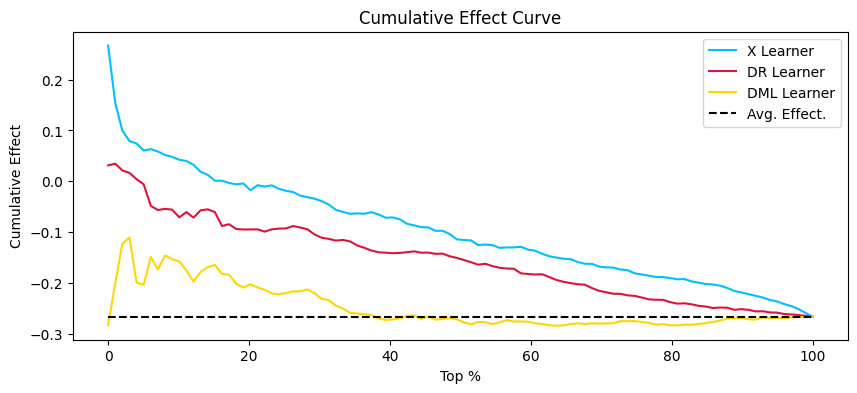

In [123]:
fig, ax = plt.subplots(figsize=(10,4))

x = np.array(range(len(cumu_effect_xl)))
ax.plot(100*(x/x.max()), cumu_effect_xl, label='X Learner', color='deepskyblue')
ax.plot(100*(x/x.max()), cumu_effect_dr, label='DR Learner', color='crimson')
ax.plot(100*(x/x.max()), cumu_effect_dml, label='DML Learner', color='gold')

ax.hlines(effect(df, y="Churn Value", t="Tech Support"), 0, 100, linestyles="--", color="black", label="Avg. Effect.")
ax.set_xlabel("Top %")
ax.set_ylabel("Cumulative Effect")
ax.set_title("Cumulative Effect Curve")
ax.legend()
plt.show()